# Feature Extraction and Image Processing
Mark S. Nixon & Alberto S. Aguado http://www.southampton.ac.uk/~msn/book/
### Chapter 4: *ImageSegmentation*
Image segmentation by using UNet model
***  

### Setup modules

In [1]:
import os
import sys
sys.path.append(os.path.join(os.path.dirname("__file__"), "../../Modules"))

# Tensor flow
import tensorflow as tf
from tensorflow.keras import models, layers
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

# For loading data
import pickle

# Module functions
from ImageUtilities import imageReadL, plotImageL, plotImageF, createImageF
from PlotUtilities import plot2Curves

### Parameters
    dataSetFileName = Name of the data file

In [2]:
dataSetFileName = "ShapesSegmentationData.pickle"

### Load dataset

In [3]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter4/Input/")
with open(pathToDir+dataSetFileName, 'rb') as f:
     data = pickle.load(f)

trainImages, trainMasks, testImages, testMasks = data 

print(trainImages.shape, trainMasks.shape, testImages.shape, testMasks.shape)
print(trainImages[0].shape, trainMasks[0].shape, testImages[0].shape, testMasks[0].shape)

(1200, 32, 32) (1200, 32, 32) (120, 32, 32) (120, 32, 32)
(32, 32) (32, 32) (32, 32) (32, 32)


### Show a train and a test image

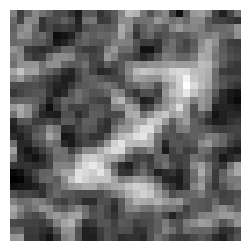

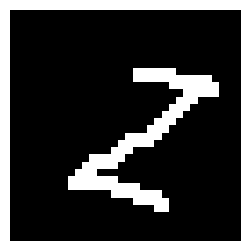

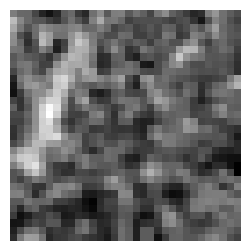

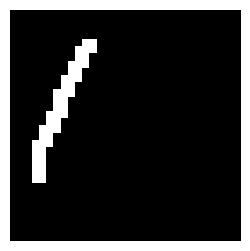

In [4]:
plotImageF(trainImages[1], figureSize = 3)
plotImageL(trainMasks[1], figureSize = 3)

plotImageF(testImages[1], figureSize = 3)
plotImageL(testMasks[1], figureSize = 3)

### Functions to create the model

In [5]:
# Create convolution layers
def creareConvolutionLayers(input, numFilters, kernelSize = 3):
   
    convolutionLayer = tf.keras.layers.Conv2D(filters = numFilters, kernel_size = (kernelSize, kernelSize),\
            kernel_initializer = 'he_normal', padding = 'same', activation='relu')(input)
    return convolutionLayer

# Encoder 
def encoder(inputs):
  
  # Convolution block and pool and drop
  convolutionFeatures1 = creareConvolutionLayers(inputs, numFilters = 64, kernelSize=3)
  maxPool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(convolutionFeatures1)
  dropOut = tf.keras.layers.Dropout(0.3)(maxPool)

  # Convolution block and pool and drop
  convolutionFeatures2 = creareConvolutionLayers(dropOut, numFilters = 128, kernelSize=3)
  maxPool = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(convolutionFeatures2)
  dropOut = tf.keras.layers.Dropout(0.3)(maxPool)

  return dropOut, (convolutionFeatures1, convolutionFeatures2)

# Botleneck
def bottleneck(inputs):

  convolutionFeatures = creareConvolutionLayers(inputs, 256, 3)
  return convolutionFeatures

# Decoder 
def decoder(inputs, convolutionLayers, numOutputChannels):
 
  convolutionFeatures1, convolutionFeatures2 = convolutionLayers

  transpose = tf.keras.layers.Conv2DTranspose(128, kernel_size = (3,3), strides = (2,2), padding = 'same')(inputs)
  concatenate = tf.keras.layers.concatenate([transpose, convolutionFeatures2])
  dropOut = tf.keras.layers.Dropout(0.3)(concatenate)
  convolution = creareConvolutionLayers(dropOut, numFilters = 128, kernelSize=3)

  transpose = tf.keras.layers.Conv2DTranspose(64, kernel_size = (3,3), strides = (2,2), padding = 'same')(convolution)
  concatenate = tf.keras.layers.concatenate([transpose, convolutionFeatures1])
  dropOut = tf.keras.layers.Dropout(0.3)(concatenate)
  convolution = creareConvolutionLayers(dropOut, numFilters = 64, kernelSize=3)
    
  outputs = tf.keras.layers.Conv2D(filters = numOutputChannels, kernel_size = (1, 1), activation='softmax')(convolution)

  return outputs    

### Create model

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 64)        │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 16, 16, 64)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 16, 16, 64)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 8, 8, 128)         │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 8, 8, 128)         │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 8, 8, 256)         │         295,168 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 16, 16, 128)       │         295,040 │ conv2d_2[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 16, 16, 256)       │               0 │ conv2d_transpose[0][0],    │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 16, 16, 256)       │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 16, 16, 128)       │         295,040 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_1            │ (None, 32, 32, 64)        │          73,792 │ conv2d_3[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 32, 32, 128)       │               0 │ conv2d_transpose_1[0][0],  │
│                               │                           │                 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               

 Total params: 1,107,458 (4.22 MB)

 Trainable params: 1,107,458 (4.22 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [7]:
trainImages2 = trainImages.reshape(trainImages.shape[0],trainImages.shape[1],trainImages.shape[2],1)
trainMasks2 = trainMasks.reshape(trainMasks.shape[0],trainMasks.shape[1],trainMasks.shape[2],1)

print(trainImages2.shape)
print(trainMasks2.shape)

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(trainImages2, trainMasks2, epochs=10)

(1200, 32, 32, 1)
(1200, 32, 32, 1)
Epoch 1/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 352ms/step - accuracy: 0.8824 - loss: 0.4013
Epoch 2/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.9529 - loss: 0.1142
Epoch 3/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9618 - loss: 0.0907
Epoch 4/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 367ms/step - accuracy: 0.9657 - loss: 0.0819
Epoch 5/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 347ms/step - accuracy: 0.9675 - loss: 0.0772
Epoch 6/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 355ms/step - accuracy: 0.9688 - loss: 0.0737
Epoch 7/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.9693 - loss: 0.0725
Epoch 8/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 14s 354ms/step - accuracy: 0.9712 - loss: 0.0681
Epoch 9/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 15s 380ms/step - accuracy: 0.9724 - loss: 0.0657
Epoch 10/10
38/38 ━━━━━━━━━━━━━━━━━━━━ 13s 351ms/step - accuracy: 0.9731 - loss: 0.0639


### Plot training

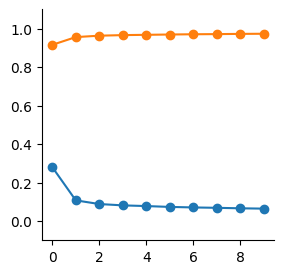

In [8]:
plot2Curves(history.history['loss'], history.history['accuracy'], rangeY = [-.1, 1.1])

### Save trained model

In [9]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter4/Input/")
modelFileName = "SegmentationModel.keras"
    
model.save(pathToDir+modelFileName)

### Load

In [10]:
pathToDir = os.path.join(os.path.dirname("__file__"), "../../Images/Chapter4/Input/")
modelFileName = "SegmentationModel.keras"

model = tf.keras.models.load_model(pathToDir+modelFileName)

# Show the model architecture
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 32, 32, 1)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 32, 32, 64)        │             640 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 16, 16, 64)        │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout (Dropout)             │ (None, 16, 16, 64)        │               0 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 16, 16, 128)       │          73,856 │ dropout[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 8, 8, 128)         │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_1 (Dropout)           │ (None, 8, 8, 128)         │               0 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 8, 8, 256)         │         295,168 │ dropout_1[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose              │ (None, 16, 16, 128)       │         295,040 │ conv2d_2[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 16, 16, 256)       │               0 │ conv2d_transpose[0][0],    │
│                               │                           │                 │ conv2d_1[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_2 (Dropout)           │ (None, 16, 16, 256)       │               0 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 16, 16, 128)       │         295,040 │ dropout_2[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_transpose_1            │ (None, 32, 32, 64)        │          73,792 │ conv2d_3[0][0]             │
│ (Conv2DTranspose)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 32, 32, 128)       │               0 │ conv2d_transpose_1[0][0],  │
│                               │                           │                 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_3 (Dropout)           │ (None, 32, 32, 128)       │               

 Total params: 3,322,376 (12.67 MB)

 Trainable params: 1,107,458 (4.22 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,214,918 (8.45 MB)

### Evaluation

In [11]:
test_loss, test_acc = model.evaluate(testImages, testMasks)
print("accuracy:", test_acc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.9704 - loss: 0.0758
accuracy: 0.9693033695220947


### Prediction

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step


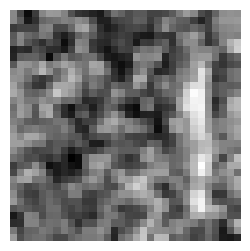

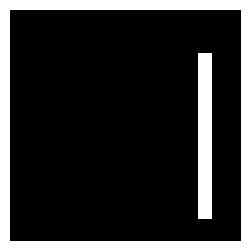

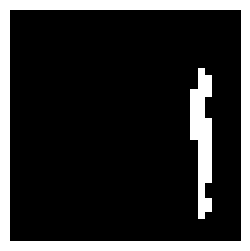

In [12]:
imageToPredict = 14

predictions=model.predict(testImages)

result = predictions[imageToPredict]
resultImage = createImageF(32,32)
for x in range(0, 32):
    for y in range(0,32):
        if result[y][x][0] < result[y][x][1]:
            resultImage[y][x] = 1

plotImageF(testImages[imageToPredict], figureSize = 3)
plotImageF(testMasks[imageToPredict], figureSize = 3)
plotImageF(resultImage, figureSize = 3)